1681999245.0072
shape: (1973, 3)
┌──────────────────┬────────┬────────┐
│ func-head        ┆ start  ┆ end    │
│ ---              ┆ ---    ┆ ---    │
│ str              ┆ f64    ┆ f64    │
╞══════════════════╪════════╪════════╡
│ fib((1|) kw={})  ┆ 0.0    ┆ 0.0    │
│ fib((0|) kw={})  ┆ 0.001  ┆ 0.001  │
│ fib((2|) kw={})  ┆ 0.0    ┆ 0.002  │
│ fib((1|) kw={})  ┆ 0.002  ┆ 0.002  │
│ ...              ┆ ...    ┆ ...    │
│ fib((9|) kw={})  ┆ 1.6499 ┆ 1.7688 │
│ fib((11|) kw={}) ┆ 1.4782 ┆ 1.7698 │
│ fib((13|) kw={}) ┆ 1.036  ┆ 1.7708 │
│ fib((15|) kw={}) ┆ 0.0    ┆ 1.7718 │
└──────────────────┴────────┴────────┘


ValueError: Invalid bbox: True

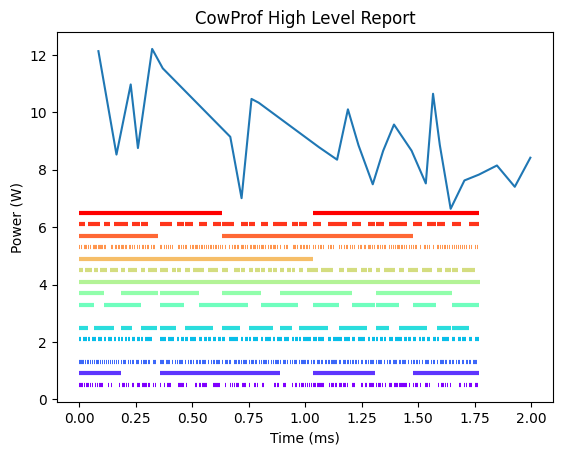

In [61]:

import polars as pl
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# getting the power usage statistics

powerdata = "data\power-logs\PowerLog-2023-04-20-10-00-44.706048"
timedata = "data\intervals\python\TimeLog-2023-04-20-10-00-44.706048.csv"
systimeshift = 0
pwr = pl.read_csv(powerdata)

pwr = pwr.with_columns([
    pl.col("System Time")
    .str.strptime(pl.Time, fmt="%H:%M:%S:%f",strict=False)
    .cast(pl.Time, strict=False),    
])

#getting the timing statistics


timing = pl.read_csv(timedata)

systimeshift = pl.min(timing.select(pl.col(["start"])).to_series())
print(systimeshift)

timing = timing.with_columns([
    pl.col("start")
        .apply(lambda x: x - systimeshift)
        .alias("start"),
    pl.col("end")
        .apply(lambda x: x - systimeshift)
        .alias("end"),
])


"""
print(timing.schema)
timing = timing.with_columns(
    pl.col("runtime")
    .cast(pl.Float64, strict=False)
    .alias("runtime")
)
"""

print(timing)

fig, ax = plt.subplots()

timeline = pwr.select(
    pl.col("Elapsed Time (sec)"
))


# plot per sample energy data
ax.plot(timeline, pwr.select(pl.col("Processor Power_0(Watt)")), label= "Overall Power (W)")

# get the different unique function headers that are being tracked
uniqueheads = set(
    timing.select(
        pl.col(
            ["func-head"]
        )
    ).to_series()
    .to_list()
)


# unique colorings for each unique function call
# Gotten from here: https://stackoverflow.com/questions/8389636/creating-over-20-unique-legend-colors-using-matplotlib
pairings, shift = {}, 0.5
color = iter(cm.rainbow(np.linspace(0, 1, len(uniqueheads))))
for item in uniqueheads:
    pairings[item] = [next(color), shift]
    shift += 0.4
   
# plot the different functions and where they be
for row in timing.rows(named=True):
    func_name = row["func-head"]
    unique_color, unique_offset = pairings[func_name]
    plt.hlines(unique_offset, 
        row["start"], 
        row["end"], 
        label=row["func-head"], 
        color=unique_color,
        linewidth=3)

# only use unique labels for repeat func calls
# from this blog post: https://itecnote.com/tecnote/python-stop-matplotlib-repeating-labels-in-legend/
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.title("CowProf High Level Report")
plt.xlabel("Time (ms)"); plt.ylabel("Power (W)")
fig.legend(by_label.values(), by_label.keys(), bbox_to_anchor=True)
fig.set_figwidth(8)

#------------------------------------------------------------------------